# DDoS Network Attack prediction

### Introduction



DDoS network attacks are malicious attempt to disrupt the normal traffic of a targeted server or network by overwhelming the target with flooding of Internet network traffic,This type of network attacks are one of the most powerful hacking techniques over the internet, However most basic weapons the hacker uses is to take down or crash the server/website is by flooding the network traffic but there are various subcategories of this attacks and each category defines the way a hacker tries to intrude into the network, We are looking for an approach that at first stage will if predict is there an network attack or traffic is normal and if there is a network attack it will predict the categorie the network attacks through ML model

About the Dataset:-

The dataset contains around 2,100,000 labelled network logs from various types of network attacks. The types of network attacks logged are: UDP-Flood, Smurf, SIDDOS, HTTP-FLOOD, & Normal traffic.

Attribute Information:

Most of the attribute are (Numerical,float) PKT_TYPE,NODE_NAME_FROM,NODE_NAME_TO,FLAG (Categorical,bytes)

class attribute -- 0= Normal traffic,1 = UDP-Flood,2= Smurf,3= SIDDOS,4= HTTP-FLOOD


### Business Problem -


While troubleshooting the incidents Network Engineers face many repeated issues which are mainly categorised into few type attacks. Most of the attacks flood the network with unwanted traffic which generate network congestion and eventually crashing the servers in turn generate large number of incidents, The number of incidents could be overwhelming during attack and correctly identifying the source of the attack and categorizing the type of the attack is the most crucial step of troubleshooting, However if we can predict proactively an ongoing attack and also what is the subcategory of the attack we are facing. We know that few types of attacks flood the network with overwhelming alarms so we can be better prepared and instead of going through all the issues at the same time we can concentrate in solving the source of the attack which in turns will resolve all other alarms.

For most of the attacks identifying the subcategory of the attack is very difficult because it involves a number of steps starting with login into devices, checking the running configuration and tracing the source of the issue at each hope etc which is very time consuming as a network engineer doesn't know the attack subcategory hence all the checks had to be performed for correctly classifying the type of attack, However if the network engineer can identify an ongoing attack and the attack subcategory proactively then he can perform specific checks to confirm the type of attack and immediately work to resolve the issues  and in turn will save the resolution time and network availability time.


### Business constraints


Mostly the cost of mis-classification is high as misclassification will lead to more time for incident resolution so we would like to have less False Positives in trade off to have more False Negatives. Meaning getting a False Positive is very costly, and a False Negative is not as much. Low time constraints as we can’t compromise with mis-classification because misclassification will lead to further delay in incident resolution, however we are trying to reduce the resolution time hence Model should not be much time consuming.

In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import pickle

from tqdm import tqdm
import os
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder

from flask import Flask, jsonify, request
import joblib



In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
df=pd.read_csv("Processed_df.csv")
df.head()

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,3.00,24.30,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.000000,50.021920,0
1,15.00,24.15,201196.0,23.0,24.0,tcp,1540.0,0,16.0,6274.0,...,328.205808,505437.0,1540.0,0.236337,0.0,20.156478,20.186848,1.000000,50.030211,0
2,24.15,15.00,61905.0,23.0,22.0,ack,55.0,0,16.0,1930.0,...,328.206042,18051.3,55.0,0.008441,0.0,7.039952,7.069962,1.030045,50.060221,1
3,24.90,9.00,443135.0,23.0,21.0,ack,55.0,0,10.0,12670.0,...,328.064183,18043.5,55.0,0.008437,0.0,39.617967,39.647976,1.030058,50.060098,0
4,24.80,8.00,157335.0,23.0,21.0,ack,55.0,0,9.0,4901.0,...,328.113525,18046.2,55.0,0.008438,0.0,16.029803,16.059813,1.030054,50.061864,0


In [4]:
y = df['PKT_CLASS'].values  # separated the class lable in Y
X = df.drop(['PKT_CLASS'], axis=1)   # combined all the features into X
X.head(1)

,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_DELAY_NODE,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED
0,3.0,24.3,389693.0,21.0,23.0,tcp,1540.0,0,4.0,11339.0,...,0.0,328.240918,505490.0,1540.0,0.236321,0.0,35.519662,35.550032,1.0,50.02192


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0002,shuffle=True,stratify=y )

### Pretrained Models

In [6]:
class_5_model = pickle.load(open('five_class_Model.pkl', 'rb'))
loaded_model_3 = pickle.load(open('Pickle_RL_Model_3.pkl', 'rb'))
loaded_model_2 = pickle.load(open('Pickle_RL_Model_2.pkl', 'rb'))
loaded_model_1 = pickle.load(open('Pickle_RL_Model_1.pkl', 'rb'))

### Pretrained Feature Engineering

In [7]:
scale = pickle.load(open('Standard_scale.pkl', 'rb'))
scale_1 = pickle.load(open('Standard_scale_1.pkl', 'rb'))
scale_2 = pickle.load(open('Standard_scale_2.pkl', 'rb'))

PKT_TYPE_LE = pickle.load(open('PKT_TYPE_LE.pkl', 'rb'))
NODE_NAME_FROM_LE = pickle.load(open('NODE_NAME_FROM_LE.pkl', 'rb'))
NODE_NAME_TO_LE = pickle.load(open('NODE_NAME_TO_LE.pkl', 'rb'))

In [8]:
def binary_classification(a):
    new_class=[]
    for i in a:    
        if i==0:
            new_class.append(0)
        else:
            new_class.append(1)
    return new_class

In [9]:
def binary_attack(a):
    new_class=[]
    for i in a:    
        if i==1:
            new_class.append(0)
        else:
            new_class.append(1)
    return new_class

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    
    phrase = re.sub(r"\'", "", phrase)
    phrase = re.sub(r"^b", "", phrase)
    phrase = re.sub(r"-", "_", phrase)
    
    return phrase

In [11]:

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in text_data:
        sent = decontracted(str(sentance))
        
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [12]:
all_columns=['SRC_ADD', 'DES_ADD', 'PKT_ID', 'FROM_NODE', 'TO_NODE', 'PKT_TYPE',
       'PKT_SIZE', 'FLAGS', 'FID', 'SEQ_NUMBER', 'NUMBER_OF_PKT',
       'NUMBER_OF_BYTE', 'NODE_NAME_FROM', 'NODE_NAME_TO', 'PKT_IN', 'PKT_OUT',
       'PKT_R', 'PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_AVG_SIZE',
       'UTILIZATION', 'PKT_DELAY', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME',
       'FIRST_PKT_SENT', 'LAST_PKT_RESEVED']

In [97]:

def function_1 (*args,b=all_columns):
    new={b[i]:args[i] for i in range(len(b))}
    df_new=pd.DataFrame((new),index =[1])
    df_new['NODE_NAME_FROM'] = preprocess_text(df_new['NODE_NAME_FROM'].values)
    df_new['NODE_NAME_TO'] = preprocess_text(df_new['NODE_NAME_TO'].values)
    df_new['PKT_TYPE'] = preprocess_text(df_new['PKT_TYPE'].values)
    
    df_new['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df_new['PKT_TYPE'])
    df_new['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df_new['NODE_NAME_FROM'])
    df_new['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df_new['NODE_NAME_TO'])
    df_new = df_new.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    
    for i in range(df_new.shape[1]):
        t=df_new.columns[i]
        new_val=scale[i].transform(df_new.values[0][i].reshape(1, -1))
        df_new[t]=new_val
        
    result=loaded_model_1.predict(df_new)
    if result == 0:
        return 'Normal traffic'
    
    else:
        df_new1=pd.DataFrame((new),index =[1])
        df_new1['NODE_NAME_FROM'] = preprocess_text(df_new1['NODE_NAME_FROM'].values)
        df_new1['NODE_NAME_TO'] = preprocess_text(df_new1['NODE_NAME_TO'].values)
        df_new1['PKT_TYPE'] = preprocess_text(df_new1['PKT_TYPE'].values)
    
        df_new1['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df_new1['PKT_TYPE'])
        df_new1['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df_new1['NODE_NAME_FROM'])
        df_new1['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df_new1['NODE_NAME_TO'])
        df_new1 = df_new1.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    
        for i in range(df_new1.shape[1]):
            t=df_new1.columns[i]
            new_val=scale_1[i].transform(df_new1.values[0][i].reshape(1, -1))
            df_new1[t]=new_val
        result1=loaded_model_2.predict(df_new1)
        if result1== 0:
            return 'UDP-Flood Attack'
        else:
            df_new2=pd.DataFrame((new),index =[1])
            df_new2['NODE_NAME_FROM'] = preprocess_text(df_new2['NODE_NAME_FROM'].values)
            df_new2['NODE_NAME_TO'] = preprocess_text(df_new2['NODE_NAME_TO'].values)
            df_new2['PKT_TYPE'] = preprocess_text(df_new2['PKT_TYPE'].values)
    
            df_new2['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df_new2['PKT_TYPE'])
            df_new2['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df_new2['NODE_NAME_FROM'])
            df_new2['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df_new2['NODE_NAME_TO'])
            df_new2 = df_new2.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    
            for i in range(df_new2.shape[1]):
                t=df_new2.columns[i]
                new_val=scale_2[i].transform(df_new2.values[0][i].reshape(1, -1))
                df_new2[t]=new_val
            result2=loaded_model_3.predict(df_new2)
            if result2 == 2:
                return 'Smurf Attack'
            elif result2 ==3:
                return 'SIDDOS Attack'
            elif result2 == 4:
                return 'HTTP-FLOOD Attack'    



In [98]:
predction=function_1(7.0, 24.7, 221770.0, 23.0, 24.0, 'tcp', 1540.0, 0, 8.0, 6914.0,
        16090.0, 24778600.0, 'router', 'server1', 22.114279999999997,
        22.114279999999997, 22.124403, 0.0, 328.167486, 505378.0, 1540.0,
        0.23630700000000002, 0.0, 22.094034, 22.124403, 1.0,
        50.029841999999995)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [99]:
print('Traffic type : ',predction)

Traffic type :  Normal traffic


In [100]:
def function_2 (x,y):
    df=pd.DataFrame(x,columns=all_columns)
    df['NODE_NAME_FROM'] = preprocess_text(df['NODE_NAME_FROM'].values)
    df['NODE_NAME_TO'] = preprocess_text(df['NODE_NAME_TO'].values)
    df['PKT_TYPE'] = preprocess_text(df['PKT_TYPE'].values)
    
    
    
    df['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df['PKT_TYPE'])
    df['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df['NODE_NAME_FROM'])
    df['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df['NODE_NAME_TO'])
    df = df.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    
    for i in range(df.shape[1]):
        t=df.columns[i]
        new_val=scale[i].transform(df[t].values.reshape(-1, 1))
        df[t]=new_val
    
    df['class_label']=y
    df['new_class']=binary_classification(df['class_label'])
    df_new_y1=df['new_class'].values
    df_new_X1 = df.drop(['class_label','new_class'], axis=1)
    Y_prediction1=loaded_model_1.predict(df_new_X1)

    
    df_new=pd.DataFrame(x,columns=all_columns)
    df_new['NODE_NAME_FROM'] = preprocess_text(df_new['NODE_NAME_FROM'].values)
    df_new['NODE_NAME_TO'] = preprocess_text(df_new['NODE_NAME_TO'].values)
    df_new['PKT_TYPE'] = preprocess_text(df_new['PKT_TYPE'].values)
   
    df_new['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df_new['PKT_TYPE'])
    df_new['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df_new['NODE_NAME_FROM'])
    df_new['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df_new['NODE_NAME_TO'])
    df_new = df_new.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    df_new['class_label']=y
    Attack_df=df_new[df_new['class_label']!=0]
  
    
   
    Attack_df['UDP_target']=binary_attack(Attack_df['class_label'].values)
    Attack_df_y2 = Attack_df['UDP_target'].values
    Attack_df_x2 = Attack_df.drop(['class_label','UDP_target'], axis=1)
    
    for i in range(Attack_df_x2.shape[1]):
        t=Attack_df_x2.columns[i]
        new_val=scale_1[i].transform(Attack_df_x2[t].values.reshape(-1, 1))
        Attack_df_x2[t]=new_val
        
    Attack_df_x2     
    Y_prediction2=loaded_model_2.predict(Attack_df_x2)
    
    
    
    df_new1=pd.DataFrame(x,columns=all_columns)
    df_new1['NODE_NAME_FROM'] = preprocess_text(df_new1['NODE_NAME_FROM'].values)
    df_new1['NODE_NAME_TO'] = preprocess_text(df_new1['NODE_NAME_TO'].values)
    df_new1['PKT_TYPE'] = preprocess_text(df_new1['PKT_TYPE'].values)
   
    df_new1['PKT_TYPE_encode']=PKT_TYPE_LE.transform(df_new1['PKT_TYPE'])
    df_new1['NODE_NAME_FROM_encode']=NODE_NAME_FROM_LE.transform(df_new1['NODE_NAME_FROM'])
    df_new1['NODE_NAME_TO_encode']=NODE_NAME_TO_LE.transform(df_new1['NODE_NAME_TO'])
    df_new1 = df_new1.drop(['PKT_TYPE','NODE_NAME_FROM','NODE_NAME_TO','FLAGS'], axis=1)
    df_new1['class_label']=y
    new_Attack_df=df_new1[df_new1['class_label']>1]
    new_Attack_df_y = new_Attack_df['class_label'].values
    new_Attack_df_x3 = new_Attack_df.drop(['class_label'], axis=1)
    for i in range(new_Attack_df_x3.shape[1]):
        t=new_Attack_df_x3.columns[i]
        new_val=scale_2[i].transform(new_Attack_df_x3[t].values.reshape(-1, 1))
        new_Attack_df_x3[t]=new_val
    Y_prediction3=loaded_model_3.predict(new_Attack_df_x3)
    
    
    return      Y_prediction1,df_new_y1,Y_prediction2,Attack_df_y2,Y_prediction3,new_Attack_df_y


In [101]:
Y_prediction1,df_new_y1,Y_prediction2,Attack_df_y2,Y_prediction3,new_Attack_df_y=function_2(X_train,y_train)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    1.1s finished


Confusion matrix, without normalization
[[1933420    2151]
 [  27990  196674]]


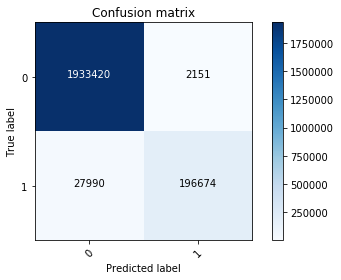

In [104]:
cnf_matrix = confusion_matrix(df_new_y1, Y_prediction1,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [105]:
print(classification_report(df_new_y1, Y_prediction1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1935571
           1       0.99      0.88      0.93    224664

    accuracy                           0.99   2160235
   macro avg       0.99      0.94      0.96   2160235
weighted avg       0.99      0.99      0.99   2160235



Confusion matrix, without normalization
[[200381    923]
 [  6759  16601]]


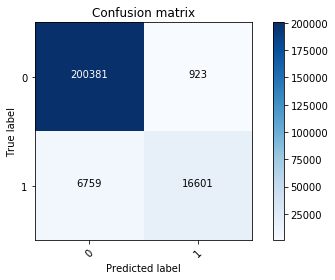

In [106]:
cnf_matrix = confusion_matrix(Attack_df_y2, Y_prediction2,labels=[0,1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')

In [107]:
print(classification_report(Attack_df_y2, Y_prediction2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    201304
           1       0.95      0.71      0.81     23360

    accuracy                           0.97    224664
   macro avg       0.96      0.85      0.90    224664
weighted avg       0.97      0.97      0.96    224664



Confusion matrix, without normalization
[[12198   345    44]
 [  357  6307     0]
 [    1   218  3890]]


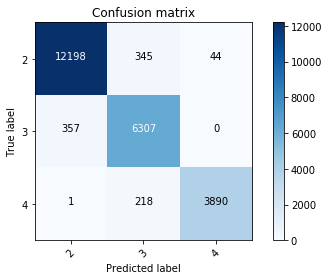

In [108]:
cnf_matrix = confusion_matrix(new_Attack_df_y, Y_prediction3,labels=[2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[2,3,4],
                      title='Confusion matrix')

In [109]:
print(classification_report(new_Attack_df_y, Y_prediction3))

              precision    recall  f1-score   support

           2       0.97      0.97      0.97     12587
           3       0.92      0.95      0.93      6664
           4       0.99      0.95      0.97      4109

    accuracy                           0.96     23360
   macro avg       0.96      0.95      0.96     23360
weighted avg       0.96      0.96      0.96     23360



In [104]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Best Model", "precision macro","recall macro","F1"]


x.add_row(['Ensembel-1','RF with 1st binary classification on 1st test set', 0.99,0.94,0.96]) 

x.add_row(['Ensembel-2','RF with 2nd binary classification on 2nd test set',  0.96,0.85,0.86]) 

x.add_row(['Ensembel-3','RF with last 3-class classification on 3rd test set', 0.96 ,0.95,0.96]) 

print(x)

+------------+-----------------------------------------------------+-----------------+--------------+------+
|   Model    |                      Best Model                     | precision macro | recall macro |  F1  |
+------------+-----------------------------------------------------+-----------------+--------------+------+
| Ensembel-1 |  RF with 1st binary classification on 1st test set  |       0.99      |     0.94     | 0.96 |
| Ensembel-2 |  RF with 2nd binary classification on 2nd test set  |       0.96      |     0.85     | 0.86 |
| Ensembel-3 | RF with last 3-class classification on 3rd test set |       0.96      |     0.95     | 0.96 |
+------------+-----------------------------------------------------+-----------------+--------------+------+
